# Residual plot


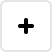
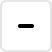
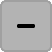
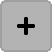
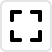
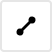
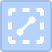
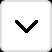
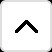
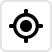

In [1]:
import numpy as np
import pandas as pd

from lets_plot import *
LetsPlot.setup_html()

In [2]:
def plot_matrix(plots=[], width=400, height=300, columns=2):
    bunch = GGBunch()
    for i in range(len(plots)):
        row = int(i / columns)
        column = i % columns
        bunch.add_plot(plots[i], column * width, row * height, width, height)
    return bunch.show()

In [3]:
# Примерное содержимое модуля lets_plot.bistro.residual

import pkg_resources
installed_packages_names = [pkg.key for pkg in pkg_resources.working_set]
for pkg_name in ['numpy', 'statsmodels', 'scipy']:
    if pkg_name not in installed_packages_names:
        raise Exception("To use this module you need to install '{0}' package".format(pkg_name))

import numpy as np

from lets_plot.plot.core import PlotSpec

METHOD_DEF = "lm"
METHOD_LM_DEG_DEF = 1
METHOD_LOESS_SPAN_DEF = .5
METHOD_LOESS_SEED_DEF = 42
GEOM_DEF = "point"
BINS_DEF = 30
MARGINAL_DEF = "dens:r"
COLOR_DEF = "#118ed8"

def _extract_data_series(data, x, y):
    xs = np.array(data[x])
    ys = np.array(data[y])
    if xs.size != ys.size:
        raise Exception("All data series in data frame must have equal size "
                        "{x_col} : {x_len} {y_col} : {y_len}".format(
            x_col=x,
            y_col=y,
            x_len=xs.size,
            y_len=ys.size
        ))
    if xs.size < 2:
        raise Exception("Data should have at least two points.")
    return xs, ys

def _poly_transform(deg):
    def _transform(X):
        assert len(X.shape) > 1 and X.shape[1] == 1
        return np.concatenate([np.power(X, d) for d in range(deg + 1)], axis=1).astype(float)
    return _transform

def _get_predictor(xs_train, ys_train, method, deg, span, seed, max_n):
    import statsmodels.api as sm
    from scipy.interpolate import interp1d

    if method == 'lm':
        X_train = xs_train.reshape(-1, 1)
        transform = _poly_transform(deg)
        model = sm.OLS(ys_train, transform(X_train)).fit()
        return lambda xs: model.predict(transform(xs.reshape(-1, 1)))
    if method in ['loess', 'lowess']:
        if max_n is not None:
            np.random.seed(seed)
            indices = np.random.choice(range(xs_train.size), size=max_n, replace=False)
            xs_train = xs_train[indices]
            ys_train = ys_train[indices]
        lowess = sm.nonparametric.lowess(ys_train, xs_train, frac=span)
        lowess_x = list(zip(*lowess))[0]
        lowess_y = list(zip(*lowess))[1]
        model = interp1d(lowess_x, lowess_y, bounds_error=False)
        return lambda xs: np.array([model(x) for x in xs])
    if method == 'none':
        return lambda xs: np.array([0] * xs.size)
    else:
        raise Exception("Unknown method '{0}'".format(method))

def _get_binwidth(xs, ys, binwidth, bins):
    if binwidth != None or bins != None:
        return binwidth
    binwidth_x = (xs.max() - xs.min()) / BINS_DEF
    binwidth_y = (ys.max() - ys.min()) / BINS_DEF
    binwidth_max = max(binwidth_x, binwidth_y)
    return [binwidth_max, binwidth_max]

def _parse_marginal(marginal, color, bins2d, binwidth2d):
    def _parse_marginal_layer(geom_name, side, size):
        layer = None
        if side not in ["l", "r", "t", "b"]:
            raise Exception("There is no side '{0}'".format(side))
        if geom_name in ["dens", "density"]:
            layer = geom_density(color=color)
        elif geom_name in ["hist", "histogram"]:
            bins = None if bins2d is None else (bins2d[0] if side in ["t", "b"] else bins2d[1])
            binwidth = None if binwidth2d is None else (binwidth2d[0] if side in ["t", "b"] else binwidth2d[1])
            layer = geom_histogram(color=color or COLOR_DEF, alpha=0, bins=bins, binwidth=binwidth)
        elif geom_name in ["box", "boxplot"]:
            layer = geom_boxplot(color=color)
        else:
            raise Exception("Unknown marginal geom '{0}'".format(self.geom))
        return ggmarginal(side, size=size, layer=layer)
    marginals = []
    for layer_description in filter(bool, marginal.split(",")):
        params = layer_description.strip().split(":")
        geom_name, sides = params[0], params[1]
        size = float(params[2]) if len(params) > 2 else None
        for side in sides:
            marginals.append(_parse_marginal_layer(geom_name, side, size))
    return marginals

def residual_plot(data=None, x=None, y=None, *,
                  method=METHOD_DEF,
                  deg=METHOD_LM_DEG_DEF,
                  span=METHOD_LOESS_SPAN_DEF, seed=METHOD_LOESS_SEED_DEF, max_n=None,
                  geom=GEOM_DEF,
                  bins=None, binwidth=None,
                  color=None, size=None, alpha=None,
                  color_by=None,
                  show_legend=None,
                  hline=True, marginal=MARGINAL_DEF):
    # prepare residuals
    residual_data = data.copy()
    xs, ys = _extract_data_series(residual_data, x, y)
    residual_col = "..residual.."
    predictor = _get_predictor(xs, ys, method, deg, span, seed, max_n)
    residual_data[residual_col] = ys - predictor(xs)
    # prepare parameters
    if isinstance(bins, int):
        bins = [bins, bins]
    if isinstance(binwidth, int) or isinstance(binwidth, float):
        binwidth = [binwidth, binwidth]
    binwidth = _get_binwidth(xs, ys, binwidth, bins)
    # prepare mapping
    mapping_dict = {'x': x, 'y': residual_col}
    if color_by != None:
        mapping_dict['color'] = color_by
    # prepare scales
    scales = []
    if method == 'none':
        scales.append(ylab(y))
    else:
        scales.append(ylab("{0} residual".format(y)))
    # prepare layers
    layers = []
    # main layer
    if geom == 'point':
        layers.append(geom_point(color=color, size=size, alpha=alpha, show_legend=show_legend))
    elif geom == 'tile':
        layers.append(geom_bin2d(
            bins=bins, binwidth=binwidth,
            color=color, size=size, alpha=alpha,
            show_legend=show_legend
        ))
    elif geom == 'blank':
        pass
    else:
        raise Exception("Unknown geom '{0}'".format(geom))
    # hline layer
    if hline:
        layers.append(geom_hline(yintercept=0, color="magenta", linetype='dashed'))
    # marginal layers
    if marginal != 'none':
        layers += _parse_marginal(marginal, color, bins, binwidth)
    # theme layer
    theme_layer = theme(axis="blank",
                        axis_text_x=element_text(),
                        axis_title_x=element_text(),
                        axis_line_y=element_line(),
                        axis_ticks_y=element_line(),
                        axis_text_y=element_text(),
                        axis_title_y=element_text())

    return PlotSpec(data=residual_data, mapping=aes(**mapping_dict), scales=scales, layers=layers) + theme_layer

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/JetBrains/lets-plot-docs/master/data/iris.csv")
print(df.shape)
df.head()

(150, 5)


sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

## Scatter plot

In [5]:
ggplot(df, aes("petal_length", "petal_width")) + geom_point()

## Default plot

In [6]:
residual_plot(df, "petal_length", "petal_width")

## Change geom type

In [7]:
residual_plot(df, "petal_length", "petal_width", geom='tile', marginal="hist:tr")

## Change method type

In [8]:
residual_plot(df, "petal_length", "petal_width", method='loess')

## Change method parameters

In [9]:
residual_plot(df, "petal_length", "petal_width", deg=3)

In [10]:
residual_plot(df, "petal_length", "petal_width", method='loess', span=.25, max_n=50)

## Method `'none'`

In [11]:
my_df = df.copy()
predictor = _get_predictor(np.array(my_df["petal_length"]), np.array(my_df["petal_width"]), "lm", 1, None, None, None)
my_df["residual for petal_width"] = my_df["petal_width"] - predictor(np.array(my_df["petal_length"]))
residual_plot(my_df, "petal_length", "residual for petal_width", method='none')

## Geometry customization

In [12]:
residual_plot(df, "petal_length", "petal_width", size=5, color="#feb24c", alpha=1/3)

In [13]:
residual_plot(df, "petal_length", "petal_width", geom="blank", color="black") + \
    geom_point(size=5, shape=21, color="black", fill="#feb24c")

In [14]:
plot_matrix([
    residual_plot(df, "petal_length", "petal_width", geom="tile", \
                  show_legend=False, marginal="hist:tr") + \
        ggtitle("Default"),
    residual_plot(df, "petal_length", "petal_width", geom="tile", \
                  show_legend=False, marginal="hist:tr", bins=10) + \
        ggtitle("bins=10"),
    residual_plot(df, "petal_length", "petal_width", geom="tile", \
                  show_legend=False, marginal="hist:tr", bins=[20, 10]) + \
        ggtitle("bins=[20, 10]"),
    residual_plot(df, "petal_length", "petal_width", geom="tile", \
                  show_legend=False, marginal="hist:tr", binwidth=.2) + \
        ggtitle("binwidth=.2"),
    residual_plot(df, "petal_length", "petal_width", geom="tile", \
                  show_legend=False, marginal="hist:tr", binwidth=[.4, .2]) + \
        ggtitle("binwidth=[.4, .2]"),
], width=500, height=375)

## Remove standard layers and add custom one

In [15]:
residual_plot(df, "petal_length", "petal_width", hline=False, marginal='none') + \
    geom_smooth(method='loess', se=True, level=.99, seed=42)

## Grouping

In [16]:
residual_plot(df, "petal_length", "petal_width", color_by="species")

## `hline` customization

In [17]:
residual_plot(df, "petal_length", "petal_width", hline=False) + geom_hline(yintercept=0, color="magenta")

## `marginal` customization

In [18]:
residual_plot(df, "petal_length", "petal_width", marginal="box:lb:.03,hist:t:.4,hist:r", color="black") + \
    theme_minimal()

In [19]:
residual_plot(df, "petal_length", "petal_width", marginal='none') + ggmarginal("tr", layer=geom_violin())

## Non-geometric layers

In [20]:
residual_plot(df, "petal_length", "petal_width") + \
    facet_grid(x="species") + \
    ggtitle("Facets")

In [21]:
residual_plot(df, "petal_length", "petal_width", color_by="species") + \
    scale_color_brewer(type="qual", palette="Dark2") + \
    ggtitle("Scales")

In [22]:
residual_plot(df, "petal_length", "petal_width", geom='tile', binwidth=[.4, .1], marginal='none') + \
    coord_fixed(ratio=.25, flip=True) + \
    ggtitle("Coordinates") + \
    theme(axis_ticks="blank", axis_text="blank", axis_line="blank")

In [23]:
residual_plot(df, "petal_length", "petal_width", color="white", binwidth=.1, marginal="hist:r") + \
    ylab("residual") + \
    theme_bw() + theme(text=element_text(family="monospace")) + \
    flavor_high_contrast_dark() + \
    ggtitle("Theme and flavor")